In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSCanonical

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
FULL_DMS = pd.read_csv('../data/dms_feature_data.csv', index_col=0)
DMS_INFO = pd.read_csv('../data/dms_info.csv', index_col=0)
ACT_SITE = pd.read_csv('../data/active_sites.csv', index_col=0)

In [3]:
# Same as https://en.wikipedia.org/wiki/Proteinogenic_amino_acid
AA_PROPERTY_SP = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Special",
    "G": "Special",
    "C": "Special",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}

# Overview of variant stability data

## ΔΔG distribution

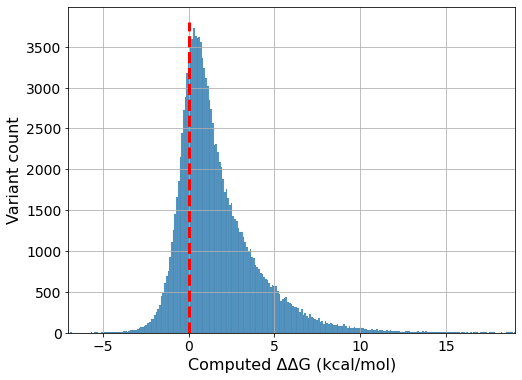

In [4]:
work_data = FULL_DMS[['pdb_id', 'uniprot_id', 'u_pos', 'aa2', 'method', 'ddG']].drop_duplicates()
work_data = work_data[work_data['ddG'].notna()]
ddg_outliers = ['1Y8M', '2DZJ', '2KR4', '2LPB', '5OB4', '7L83']

fig, ax = plt.subplots(1,1, figsize=(8,6))
fig.set_facecolor('w')
sns.histplot(work_data.query("pdb_id not in @ddg_outliers")['ddG'])
plt.xlim([-7,19])
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.xlabel('Computed ΔΔG (kcal/mol)', fontsize=16)
plt.ylabel('Variant count', fontsize=16)
plt.grid()
plt.vlines(0, 0, 3800, color=[(1,0,0)], linestyle='--', linewidth=3)
plt.show()

In [5]:
work_data = FULL_DMS[['pdb_id', 'uniprot_id', 'u_pos', 'aa2', 'method', 'ddG']].drop_duplicates()
work_data = work_data[work_data['ddG'].notna()]
print(np.sum(work_data['ddG']<0)/len(work_data))

0.2159556074421079


## ρ(-ΔΔG, DMS) on each amino acid

aa1 0.1777082583791764
aa2 0.20421959677024137


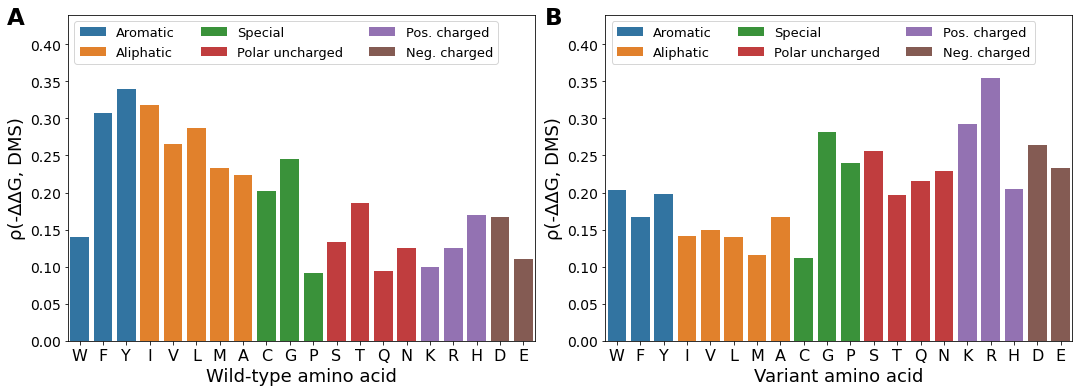

In [6]:
ddg_outliers = ['1Y8M', '2DZJ', '2KR4', '2LPB', '5OB4', '7L83']
work_data = FULL_DMS.query("pdb_id not in @ddg_outliers")
work_data = work_data[['dms_id', 'position', 'aa1', 'aa2', 'score', 'ddG']].drop_duplicates()
work_data = work_data[work_data['ddG'].notna()]


def foo(work_data, group_aa, ax, xlabel, text):
    aa_order = [x for x in 'WFYIVLMACGPSTQNKRHDE']
    corr = dict()
    med_score = dict()
    for aa, data in work_data.groupby(group_aa):
        data = data[['ddG', 'score']].dropna()
        corr[aa] = -spearmanr(data['ddG'], data['score'])[0]
        med_score[aa] = data.score.median()
    vis_data = pd.DataFrame([corr, med_score], index=['ρ(-ΔΔG, DMS)', 'Med. DMS']).T
    vis_data['aa_property'] = vis_data.index.map(AA_PROPERTY_SP)
    vis_data = vis_data.loc[aa_order]
    print(group_aa, vis_data['ρ(-ΔΔG, DMS)'].median())
    
    sns.barplot(x=vis_data.index, y=vis_data['ρ(-ΔΔG, DMS)'], hue=vis_data['aa_property'], 
                ax=ax, dodge=False)
    
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel('ρ(-ΔΔG, DMS)', fontsize=18)
    ax.legend(loc=2, ncol=3, fontsize=13)
    ax.set_ylim(0,0.44)
    ax.text(-0.13,0.97,text,fontsize=23,weight='bold',transform=ax.transAxes)
    return


fig, axs = plt.subplots(1,2,figsize=(18,6))
fig.set_facecolor('w')
plt.subplots_adjust(wspace=0.15)
foo(work_data, 'aa1', axs[0],'Wild-type amino acid', 'A')
foo(work_data, 'aa2', axs[1],'Variant amino acid', 'B')
plt.show()

## ρ(-ΔΔG, DMS) on each assay type

In [9]:
work_data = FULL_DMS[['dms_id', 'position', 'aa2', 'ddG', 'gemme_score', 'score']].copy()
work_data = work_data[work_data['ddG'].notna() & work_data['gemme_score'].notna()]

dms_fcorr = dict()
for dms, df in work_data.groupby('dms_id'):
    row = dict()
    row['ρ(-ΔΔG, DMS)'] = spearmanr(df['score'], -df['ddG'])[0]
    row['ρ(GEMME, DMS)'] = spearmanr(df['score'], df['gemme_score'])[0]
    dms_fcorr[dms] = row
dms_fcorr = pd.DataFrame(dms_fcorr).T
dms_fcorr['diff'] = dms_fcorr['ρ(-ΔΔG, DMS)'] - dms_fcorr['ρ(GEMME, DMS)']
dms_fcorr['DMS assay type'] = dms_fcorr.index.map(DMS_INFO.groupby('dms_id')['assay_g02'].first())

assay_count = dms_fcorr.groupby('DMS assay type').count()['diff']
for key, val in assay_count.items():
    assay_count[key] = f"{key}\n(n={assay_count[key]})"
dms_fcorr['DMS assay type'] = dms_fcorr['DMS assay type'].map(assay_count)

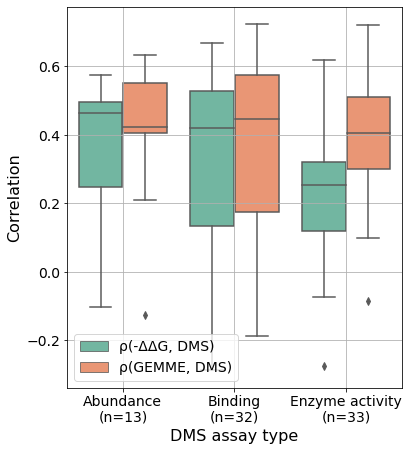

In [10]:
vis_data = dms_fcorr.reset_index().rename(columns={'index': 'dms_id'})
vis_data = vis_data.melt(id_vars=['dms_id', 'DMS assay type'], value_vars=['ρ(-ΔΔG, DMS)', 'ρ(GEMME, DMS)'], 
                         var_name='Feature', value_name='Correlation')

fig, ax = plt.subplots(1,1,figsize=(6,7))
sns.boxplot(data=vis_data, x='DMS assay type', hue='Feature', y='Correlation', ax=ax, palette='Set2', 
            order=['Abundance\n(n=13)', 'Binding\n(n=32)', 'Enzyme activity\n(n=33)'], #notch=True,
            hue_order=['ρ(-ΔΔG, DMS)', 'ρ(GEMME, DMS)'])
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.legend(fontsize=14, loc=3)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
plt.grid()
plt.show()

# Distinguish DMS-stability association on residues

## DMS-stability correlation on five adjacent residues

In [11]:
def foo_vis_residue_fcorr(ax, input_data, u_range, cbar_ax=None, cmap='bwr_r', ticks=[]):
    vis_data = input_data.copy()
    vis_data.index = vis_data.u_pos
    for upos in range(1, vis_data.u_pos.min()):
        vis_data.loc[upos] = [np.nan] * len(input_data.iloc[0])
    vis_data = vis_data.sort_index().loc[u_range[0]:u_range[1]+1,:]
    cmap = plt.cm.get_cmap(cmap).copy()
    cmap.set_bad([0.75,]*3)
    
    g = sns.heatmap(vis_data[['ρ(-ΔΔG, DMS)  ', 'ρ(GEMME, DMS)']].T, ax=ax, cmap=cmap, cbar=True, 
                    cbar_ax=cbar_ax, vmin=-1, vmax=1)
    cbar_ax.tick_params(labelsize=14)
    ax.hlines(1, *ax.get_xlim(), colors='w')
    ticks_pos = [x-u_range[0]+0.5 for x in ticks]
    ax.set_xticks(ticks_pos)
    ax.set_xticklabels(ticks)
    ax.set_ylabel('')
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=16)
    return


def foo_vis_dms_ddg_gemme_plots(ax_list, input_data, multires_mode=False, u_range=None):
    work_data = input_data[['u_pos', 'ddG', 'gemme_score', 'score']].copy()
    
    if multires_mode:
        result = []
        for u_pos in work_data['u_pos'].sort_values().unique()[1:-1]:
            foo = work_data.query(f"u_pos <= @u_pos+{2} & u_pos >= @u_pos-{2}")
            foo = foo.dropna().median()
            foo['u_pos'] = u_pos
            result.append(foo)
        work_data = pd.concat(result, axis=1).T
    else:
        work_data = work_data.groupby('u_pos', as_index=False).median()
        
    if u_range is not None:
        work_data['u_pos'] = work_data['u_pos'] - u_range[0] + 1
        
    ax_list[0].scatter(work_data['u_pos']-0.5, work_data['score'], s=20)
    ax_list[0].set_ylabel('DMS score', rotation=0, ha='right', va='center', fontsize=16)
    plt.setp(ax_list[0].get_yticklabels(), fontsize=14)
    ax_list[0].grid()
    ax_list[1].scatter(work_data['u_pos']-0.5, -work_data['ddG'], s=20)
    ax_list[1].set_ylabel('-ΔΔG    ', rotation=0, ha='right', va='center', fontsize=16)
    plt.setp(ax_list[1].get_yticklabels(), fontsize=14)
    ax_list[1].grid()
    ax_list[2].scatter(work_data['u_pos']-0.5, work_data['gemme_score'], s=20)
    ax_list[2].set_ylabel('GEMME', rotation=0, ha='right', va='center', fontsize=16)
    plt.setp(ax_list[2].get_yticklabels(), fontsize=14)
    ax_list[2].grid()
    return work_data

In [12]:
res_fcorr = []
for dms, vis_data in FULL_DMS.groupby('dms_id'):
    if dms not in ['urn:mavedb:00000086-e-1']:
        continue
    u_pos_range = np.sort(vis_data['u_pos'].unique())
    if len(u_pos_range) < 3:
        continue
    for pos in u_pos_range[1:-1]:  # Should check if three consecutive residues exist, omitted for now.
        row = dict()
        work_data = vis_data.query(f"u_pos <= @pos+{2} & u_pos >= @pos-{2}")
        work_data = work_data[['ddG', 'gemme_score', 'score']].copy().dropna()
        row['ρ(-ΔΔG, DMS)  '] = spearmanr(-work_data['ddG'], work_data['score'])[0]
        row['ρ(GEMME, DMS)'] = spearmanr(work_data['gemme_score'], work_data['score'])[0]
        row['u_pos'] = pos
        row['dms_id'] = dms
        res_fcorr.append(row)
res_fcorr = pd.DataFrame(res_fcorr)
res_fcorr['diff'] = res_fcorr['ρ(-ΔΔG, DMS)  '] - res_fcorr['ρ(GEMME, DMS)']

In [13]:
dms = 'urn:mavedb:00000086-e-1'
unip = 'P62593'
print(sorted(ACT_SITE.query("uniprot_id == @unip")['u_pos'].unique()))

[68, 71, 128, 164, 232, 235]


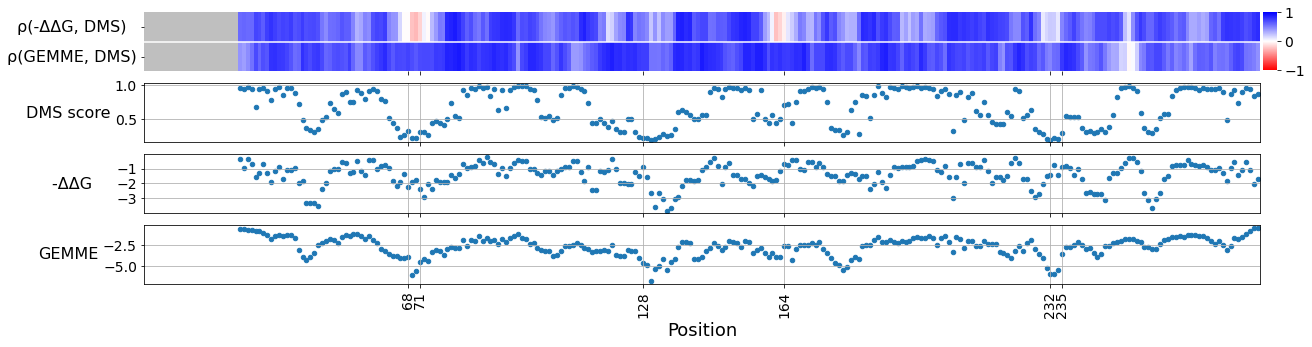

In [14]:
dms_name = 'TEM1-Stiffler-2500'
dms_id = DMS_INFO.query("dms_name == @dms_name")['dms_id'].iloc[0]
u_range = [1,300]
annots = [68, 71, 128, 164, 232, 235]

fig, axs = plt.subplots(4,1,figsize=(20, 5),sharex=True)
fig.patch.set_facecolor('w')
cbar_ax = fig.add_axes([0.902,0.72,0.01,0.16])
foo_vis_residue_fcorr(axs[0], res_fcorr.query("dms_id==@dms_id"), u_range, 
                      cbar_ax=cbar_ax, ticks=annots)
foo_vis_dms_ddg_gemme_plots([axs[1], axs[2], axs[3]], FULL_DMS.query("dms_id==@dms_id"), 
                            multires_mode=True, u_range=u_range)
axs[0].set_xlabel(None)
axs[3].set_xlabel('Position', fontsize=18)
axs[3].set_xticklabels(annots, rotation=90, fontsize=14)
plt.show()

## Canonical Partial Least Squares (CPLS) on β-lactmase (high antibiotics concentration) 

### Modelling

In [15]:
dms = 'urn:mavedb:00000086-e-1'
df = FULL_DMS.query("dms_id == @dms")
cca_data = df[['u_pos', 'aa1', 'aa2', 'score', 'relative_acc', 'norm_bfactor',  'ddG', 'gemme_score', 'uniprot_id']]
ddg_avai_upos = cca_data[cca_data['ddG'].notna()]['u_pos'].unique()
cca_data = cca_data.query("u_pos in @ddg_avai_upos")

# Make wildtype data.
wt_data = cca_data[['u_pos', 'aa1', 'uniprot_id', 'relative_acc', 'norm_bfactor']].copy().drop_duplicates()
wt_data['aa2'] = wt_data['aa1']
wt_data['score'] = 1
wt_data['ddG'] = 0
wt_data['gemme_score'] = 0
cca_data = pd.concat([cca_data, wt_data], ignore_index=True)
cca_data['upos_id'] = cca_data['uniprot_id'] + '_' + cca_data['u_pos'].astype(int).astype(str)

# Pivot data.
cca_data = cca_data.rename(columns={'gemme_score': 'gemme', 'ddG': 'ddg'})  # For consistency.
cca_data = cca_data.pivot(index=['upos_id', 'relative_acc', 'norm_bfactor'], 
                          columns='aa2', values=['score', 'ddg', 'gemme'])
cca_data.columns = ["_".join(x) for x in cca_data.columns.to_flat_index()]
cca_data = cca_data.reset_index(level=[1,2])  # upos_id is used as index.

# Impute missing values.
imputed_cca = []
for prefix in ['scor', 'ddg_', 'gemm']:
    foo = cca_data[[x for x in cca_data.columns if x[:4] == prefix]].copy()
    foo = foo.T.fillna(foo.mean(axis=1)).T
    imputed_cca.append(foo)
# Impute missing B-F & RelAcc.
foo = cca_data[['relative_acc', 'norm_bfactor']].copy()
foo = foo.fillna(foo.mean())
foo = foo.fillna(0)  # Sometimes, certain data have none B-F or RelAcc available.
imputed_cca.append(foo)
cca_data = pd.concat(imputed_cca, axis=1)

# Modelling
set_n_components = 15
np.random.seed(0)
model = PLSCanonical(n_components=set_n_components)
feature_s, score_s = model.fit_transform(cca_data[['relative_acc', 'norm_bfactor']+\
                                                  [x for x in cca_data.columns if x[:4] in ['gemm', 'ddg_']]], 
                                         cca_data[[x for x in cca_data.columns if x[:4] == 'scor']])
feature_s = pd.DataFrame(feature_s, index=cca_data.index, columns=[f"PLSCanonical_feature_{i}" for i in range(set_n_components)])
score_s = pd.DataFrame(score_s, index=cca_data.index, columns=[f"PLSCanonical_score_{i}" for i in range(set_n_components)])
cca_output = pd.concat([cca_data, feature_s, score_s], axis=1)
cca_output['dms_id'] = dms

# In this DMS example, the first two dimensions have the first and second highest canonical correlations.
# So, no sorting on the first two dimensions is required.
tem1_high_result = cca_output.copy()

### Canonical correlation

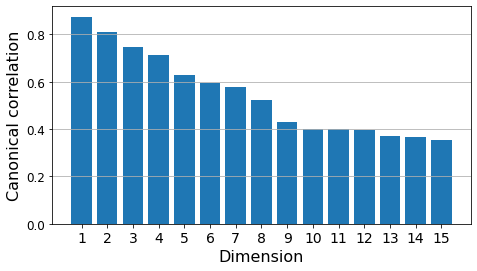

In [16]:
work_data = tem1_high_result.copy()
set_n_components = 15

data = pd.Series(dtype=float)
for i in range(set_n_components):
    # https://stackoverflow.com/questions/40832695/calculating-n-th-canonical-correlation-and-coefficients-with-python-scikit-learn
    corr = pearsonr(work_data[f"PLSCanonical_feature_{i}"], work_data[f"PLSCanonical_score_{i}"])[0]
    data.loc[i] = np.round(corr, 4)
fig, ax = plt.subplots(1,1,figsize=(set_n_components/2,4))
ax.bar(data.index, data.sort_values(ascending=False))
plt.xticks(np.arange(set_n_components), labels=np.arange(set_n_components)+1, fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.ylabel('Canonical correlation', fontsize=16)
plt.xlabel('Dimension', fontsize=16)
plt.grid(axis='y')
plt.show()

### Deconvolution on residues

In [17]:
n_components = 15

cca_results = tem1_high_result.copy()
cca_results['u_pos'] = cca_results.index.str.split('_').str[1].astype(int)
cca_results['uniprot_id'] = cca_results.dms_id.map(FULL_DMS.groupby('dms_id')['uniprot_id'].first())
cca_results[f"score_median"] = cca_results[[f"score_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
cca_results[f"ddg_median"] = cca_results[[f"ddg_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
cca_results[f"gemme_median"] = cca_results[[f"gemme_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
for i in range(n_components):
    cca_results[f"PLSCanonical_mean_{i}"] = (cca_results[f"PLSCanonical_feature_{i}"] + cca_results[f"PLSCanonical_score_{i}"]) / 2

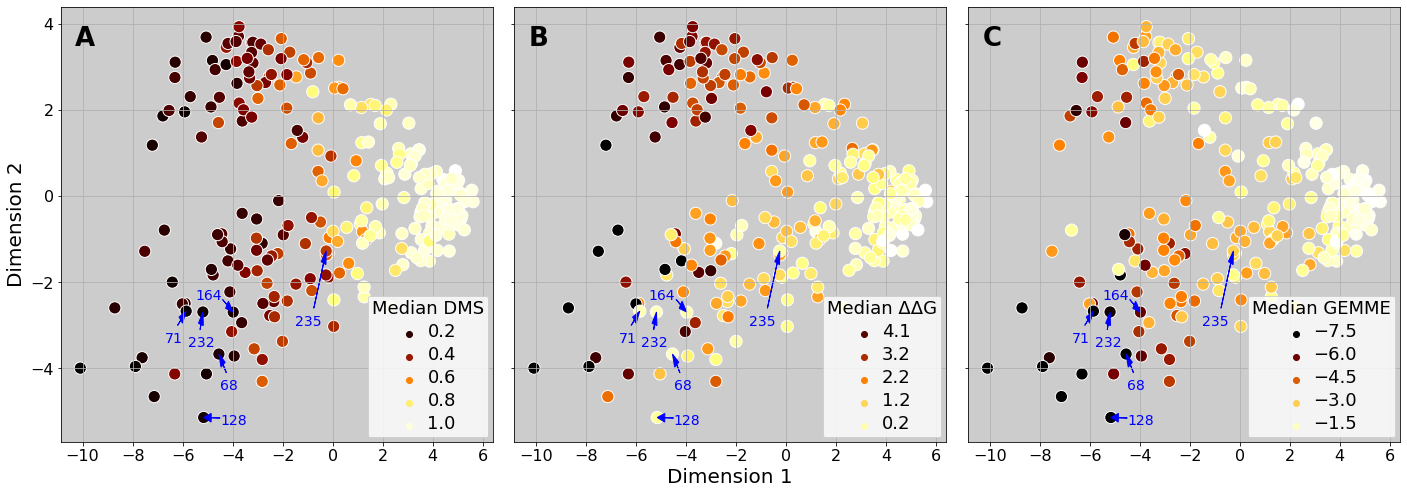

u_pos                                       235
Median ΔΔG                             0.334138
Median GEMME                          -2.983191
Median DMS                             0.465496
  Median DMS on\naliphatic variants    0.535909
Name: 235, dtype: object

In [18]:
def foo(ax, vis_data, method, hue_target, annot=None, hue_norm_quart=None, set_handle=False):
    if hue_target == 'Median ΔΔG':
        cmap = 'afmhot_r'
    else:
        cmap = 'afmhot'

    if hue_norm_quart is None:
        g = sns.scatterplot(data=vis_data, x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, 
                            palette=cmap, s=150, ax=axs[i], zorder=0)
    else:
        vmin = vis_data[hue_target].quantile(hue_norm_quart[0])
        vmax = vis_data[hue_target].quantile(hue_norm_quart[1])
        if set_handle:
            g = sns.scatterplot(data=vis_data, x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, 
                                palette=cmap, s=150, ax=axs[i], hue_norm=(vmin, vmax), legend='full', zorder=0)
            handles, labels = g.get_legend_handles_labels()
            sample_vals = np.linspace(vmin, vmax, 7)[1:-1]
            closest_handle_index = []
            labels_vals = np.array([float(x) for x in labels])
            for val in sample_vals:
                closest_handle_index.append(np.abs(labels_vals - val).argmin())
            closest_handle_index = list(reversed(closest_handle_index))
            ax.legend(handles=[handles[i] for i in closest_handle_index], 
                      labels=[np.round(float(labels[i]), 1) for i in closest_handle_index],
                      title=hue_target)
            
        else:
            g = sns.scatterplot(data=vis_data, x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, 
                                palette=cmap, s=150, ax=axs[i], hue_norm=(vmin, vmax), legend='brief', zorder=0)
            
    if annot is not None:
        #sns.scatterplot(data=vis_data.loc[annot,:], x=f"{method}_mean_0", y=f"{method}_mean_1", 
        #                color='cyan', s=350, ax=axs[i])
        for upos, (x, y, dx, dy) in annot.items():
            ax.arrow(x+dx, y+dy, vis_data.loc[upos,f"{method}_mean_0"]-x-dx, vis_data.loc[upos,f"{method}_mean_1"]-y-dy,
                     head_width=0.2, alpha=1, length_includes_head=True, color='b', zorder=1)
            ax.text(x, y, upos, fontsize=14, color='b')

    plt.setp(axs[i].get_legend().get_texts(), fontsize=18)
    plt.setp(axs[i].get_legend().get_title(), fontsize=18)
    axs[i].set_facecolor([0.8,]*3)
    axs[i].grid()
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    plt.setp(axs[i].get_xticklabels(), fontsize=16)
    plt.setp(axs[i].get_yticklabels(), fontsize=16)
    return


# TEM-1 2500
dms = 'urn:mavedb:00000086-e-1'
vis_data = cca_results.query("dms_id == @dms").copy()
unip = vis_data.uniprot_id.unique()[0]
annot = [68, 71, 128, 164, 232, 235]
vis_data.index = vis_data.u_pos
# Re-order vis_data a bit so that the enzyme active sites are on the top.
vis_data = vis_data.loc[[x for x in vis_data.index if x not in annot]+annot,:]
vis_data['hypho_score_med'] = vis_data[[f"score_{x}" for x in 'AVILM']].median(axis=1)
vis_data['-ddg_median'] = -vis_data['ddg_median']
hue_map = dict(zip(['ddg_median', 'gemme_median', 'score_median', 'hypho_score_med'],
                   ['Median ΔΔG', 'Median GEMME', 'Median DMS', '  Median DMS on\naliphatic variants']))
vis_data = vis_data.rename(columns=hue_map)

fig, axs = plt.subplots(1,3,figsize=(24,8), sharex=True, sharey=True)
axs = axs.reshape(-1)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.set_facecolor('w')
hue_target = dict(zip([0,1,2,3],['Median DMS', 'Median ΔΔG', 'Median GEMME', '  Median DMS on\naliphatic variants']))
# To diminish the influence of extreme values on the color palette.
norms = dict(zip([0,1,2,3], [(0,1),(0.03,0.97),(0.03,0.97),(0,1)])) 
annot_vis = dict(zip(annot, [(-4.5,-4.5,0.25,0.4), (-6.7,-3.4,0.5,0.4), (-4.5,-5.3,0,0.15), 
                             (-5.5,-2.4,1.1,0), (-5.8,-3.5,0.5,0.4), (-1.5,-3,0.75,0.4)]))

for i in range(3):
    set_handle = False
    if i == 1:
        set_handle = True
    foo(axs[i], vis_data, 'PLSCanonical', hue_target[i], 
        annot=annot_vis, hue_norm_quart=norms[i], set_handle=set_handle)
axs[0].set_ylabel('Dimension 2', fontsize=20)
axs[1].set_xlabel('Dimension 1', fontsize=20)
for i, char in enumerate('ABC'):
    axs[i].text(-10.3,3.5,char,fontsize=26, weight='bold')
plt.show()

vis_data.loc[235][['u_pos','Median ΔΔG', 'Median GEMME', 'Median DMS', '  Median DMS on\naliphatic variants']]

In [25]:
cca_results.query("dms_id=='urn:mavedb:00000086-e-1' & PLSCanonical_mean_0<=-2 & PLSCanonical_mean_1<=-2")['u_pos'].sort_values().values

array([ 35,  43,  68,  71, 104, 105, 128, 129, 130, 132, 134, 141, 142,
       154, 161, 164, 168, 174, 177, 212, 215, 224, 231, 232, 233, 234,
       236, 242])

## CPLS on β-lactmase of high & low antibiotics concentration

In [20]:
def foo_multi_dms_cca(input_data, n_components=10):
    cca_data = input_data[['u_pos', 'aa1', 'aa2', 'score', 'relative_acc', 'norm_bfactor',  'ddG', 
                           'gemme_score', 'uniprot_id', 'dms_id']].copy()
    ddg_avai_upos = cca_data[cca_data['ddG'].notna()]['u_pos'].unique()
    cca_data = cca_data.query("u_pos in @ddg_avai_upos")
    
    # Add wildtype data.
    full_wt_data = []
    for dms, df in cca_data.groupby('dms_id'):
        wt_data = df[['u_pos', 'aa1', 'uniprot_id', 'relative_acc', 'norm_bfactor', 'dms_id']].copy().drop_duplicates()
        wt_data['aa2'] = wt_data['aa1']
        wt_data['score'] = 1
        wt_data['ddG'] = 0
        wt_data['gemme_score'] = 0
        full_wt_data.append(wt_data)
    cca_data = pd.concat([cca_data] + full_wt_data, ignore_index=True)
    cca_data['dpos_id'] = cca_data['dms_id'] + '_' + cca_data['u_pos'].astype(int).astype(str)

    # Pivot data.
    cca_data = cca_data.rename(columns={'gemme_score': 'gemme', 'ddG': 'ddg'})  # For consistency.
    cca_data = cca_data.pivot(index=['dpos_id', 'relative_acc', 'norm_bfactor'], 
                              columns='aa2', values=['score', 'ddg', 'gemme'])
    cca_data.columns = ["_".join(x) for x in cca_data.columns.to_flat_index()]
    cca_data = cca_data.reset_index(level=[1,2])  # dpos_id is used as index.

    # Impute missing values.
    imputed_cca = []
    for prefix in ['scor', 'ddg_', 'gemm']:
        foo = cca_data[[x for x in cca_data.columns if x[:4] == prefix]].copy()
        foo = foo.T.fillna(foo.mean(axis=1)).T
        imputed_cca.append(foo)
    # Impute missing B-F & RelAcc.
    foo = cca_data[['relative_acc', 'norm_bfactor']].copy()
    foo = foo.fillna(foo.mean())
    foo = foo.fillna(0)  # Sometimes, certain data have none B-F or RelAcc available.
    imputed_cca.append(foo)
    cca_data = pd.concat(imputed_cca, axis=1)

    if len(cca_data) < n_components:
        set_n_components = len(cca_data)
    else:
        set_n_components = n_components

    cca_output = cca_data.copy()
    for name in ['PLSCanonical']:
        if name == 'CCA':
            model = CCA(n_components=set_n_components)
        elif name == 'PLSCanonical':
            model = PLSCanonical(n_components=set_n_components)
        elif name == 'PLSRegression':
            model = PLSRegression(n_components=set_n_components)
        else:
            model = PLSSVD(n_components=set_n_components)
        feature_s, score_s = model.fit_transform(cca_data[['relative_acc', 'norm_bfactor'] + \
                                                          [x for x in cca_data.columns if x[:4] in ['gemm', 'ddg_']]], 
                                                 cca_data[[x for x in cca_data.columns if x[:4] == 'scor']])
        feature_s = pd.DataFrame(feature_s, index=cca_data.index, columns=[f"{name}_feature_{i}" for i in range(set_n_components)])
        score_s = pd.DataFrame(score_s, index=cca_data.index, columns=[f"{name}_score_{i}" for i in range(set_n_components)])
        cca_output = pd.concat([cca_output, feature_s, score_s], axis=1)
    cca_output = cca_output.reset_index()
    cca_output['dms_id'] = cca_output.dpos_id.str.split('_').str[0]
    cca_output['u_pos'] = cca_output.dpos_id.str.split('_').str[1]
    return cca_output

In [21]:
query_dms = ['urn:mavedb:00000086-e-1', 'urn:mavedb:00000086-b-1']
n_components = 15

cca_output = foo_multi_dms_cca(FULL_DMS.query("dms_id in @query_dms"), n_components=n_components)
cca_output['uniprot_id'] = cca_output.dms_id.map(FULL_DMS.groupby('dms_id')['uniprot_id'].first())
cca_output[f"score_median"] = cca_output[[f"score_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
cca_output[f"ddg_median"] = cca_output[[f"ddg_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
cca_output[f"gemme_median"] = cca_output[[f"gemme_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
for i in range(n_components):
    cca_output[f"PLSCanonical_mean_{i}"] = (cca_output[f"PLSCanonical_feature_{i}"] + cca_output[f"PLSCanonical_score_{i}"]) / 2
tem1_output = cca_output.copy()

In [22]:
vis_data = tem1_output.copy()
annot = [68, 71, 128, 164, 232, 235]  # 166 is wrong active site by UniProt.
vis_data.index = vis_data.u_pos.astype(int)
vis_data['-ddg_median'] = -vis_data['ddg_median']
hue_map = dict(zip(['ddg_median', 'gemme_median', 'score_median', 'hypho_score_med'],
                   ['Median ΔΔG', 'Median GEMME', 'Median DMS', '  Median DMS on\naliphatic variants']))
vis_data = vis_data.rename(columns=hue_map)

pivot_data = tem1_output.copy()
pivot_data = pivot_data.pivot(index=['u_pos', 'ddg_median'], columns='dms_id', values=[f"PLSCanonical_mean_0", f"PLSCanonical_mean_1"])
dms_name_map = {'urn:mavedb:00000086-b-1': '39 mg/L', 
                'urn:mavedb:00000086-e-1': '2500 mg/L'}
pivot_data.columns = [f"{dms_name_map[x[1]]}_dim_{x[0][-1]}" for x in pivot_data.columns.to_flat_index()]
for (start_c, end_c) in [(39,2500)]:
    pivot_data[f"{start_c} -> {end_c} mg/L dist."] = np.sqrt((pivot_data[f"{end_c} mg/L_dim_0"] - pivot_data[f"{start_c} mg/L_dim_0"])**2 + (pivot_data[f"{end_c} mg/L_dim_0"] - pivot_data[f"{start_c} mg/L_dim_0"])**2)
pivot_data = pivot_data.reset_index()
pivot_data.u_pos = pivot_data.u_pos.astype(int)

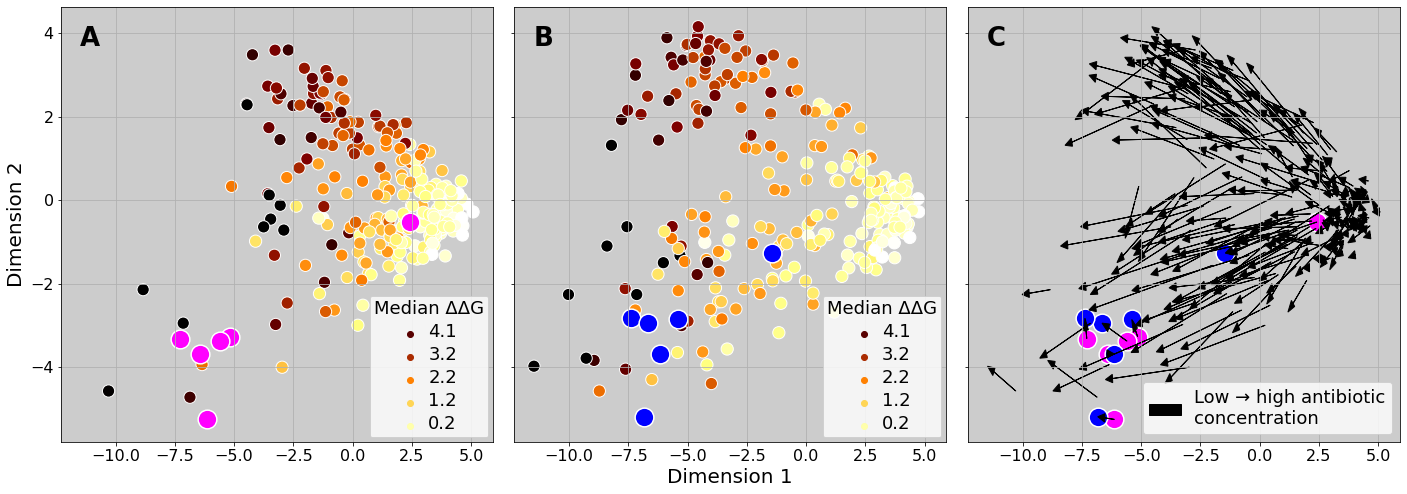

In [23]:
def foo_scatter(ax, vis_data, method, hue_target, annot=None, hue_norm_quart=None, set_handle=False, c=None):
    cmap = 'afmhot_r'

    if annot is not None:
        sns.scatterplot(data=vis_data.loc[annot,:], x=f"{method}_mean_0", y=f"{method}_mean_1", 
                        color=c, s=350, ax=ax, zorder=1)
    
    if hue_norm_quart is None:
        g = sns.scatterplot(data=vis_data, x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, 
                            palette=cmap, s=150, ax=ax, zorder=0)
    else:
        vmin = vis_data[hue_target].quantile(hue_norm_quart[0])
        vmax = vis_data[hue_target].quantile(hue_norm_quart[1])
        if set_handle:
            g = sns.scatterplot(data=vis_data, x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, 
                                palette=cmap, s=150, ax=ax, hue_norm=(vmin, vmax), legend='full', zorder=0)
            handles, labels = g.get_legend_handles_labels()
            sample_vals = np.linspace(vmin, vmax, 7)[1:-1]
            closest_handle_index = []
            labels_vals = np.array([float(x) for x in labels])
            for val in sample_vals:
                closest_handle_index.append(np.abs(labels_vals - val).argmin())
            closest_handle_index = list(reversed(closest_handle_index))
            ax.legend(handles=[handles[i] for i in closest_handle_index], 
                      labels=[np.round(float(labels[i]), 1) for i in closest_handle_index],
                      title=hue_target)
            
        else:
            g = sns.scatterplot(data=vis_data, x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, 
                                palette=cmap, s=150, ax=ax, hue_norm=(vmin, vmax), legend='brief', zorder=0, )
            

    sns.move_legend(g, loc=4)
    plt.setp(ax.get_legend().get_texts(), fontsize=18)
    plt.setp(ax.get_legend().get_title(), fontsize=18)
    ax.set_facecolor([0.8,]*3)
    ax.grid()
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    return


def foo_arrow(ax, input_data, method, dms_2, name_2, dms_3, name_3, annot):
    pivot_data = input_data.copy()
    
    work_data = pivot_data.query("u_pos in @annot")
    for i, col_prefix in enumerate(['39 mg/L_dim_', '2500 mg/L_dim_']):
        c = ['magenta','b', ][i]
        sns.scatterplot(data=work_data, x=f"{col_prefix}0", y=f"{col_prefix}1", ax=ax, color=c, s=350, zorder=0)


    label = 'Low → high antibiotic\nconcentration'
    for upos, row in pivot_data.iterrows():
        alpha = row["39 -> 2500 mg/L dist."]/6  # Determined by the maximum value
        if (alpha > 1) | np.isnan(alpha):
            alpha = 1
        if alpha < 0.3:
            alpha=0.3
        alpha=1
        ax.arrow(row[f"{name_2}_dim_0"], row[f"{name_2}_dim_1"],
                 row[f"{name_3}_dim_0"]-row[f"{name_2}_dim_0"], 
                 row[f"{name_3}_dim_1"]-row[f"{name_2}_dim_1"], 
                 head_width=0.2, alpha=alpha, length_includes_head=True, color='k', label=label, zorder=1)
        if label is not None:
            label = None
            
    ax.legend(fontsize=16, loc=4)
    plt.setp(ax.get_legend().get_texts(), fontsize=18)
    plt.setp(ax.get_legend().get_title(), fontsize=18)
    ax.set_facecolor([0.8,]*3)
    ax.grid()
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)


fig, axs = plt.subplots(1,3,figsize=(24,8), sharex=True, sharey=True)
axs = axs.reshape(-1)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.set_facecolor('w')

set_handle = True
for i, dms in enumerate(['urn:mavedb:00000086-b-1', 'urn:mavedb:00000086-e-1', ]):
    foo_scatter(axs[i], vis_data.query("dms_id==@dms"), 'PLSCanonical', 
                'Median ΔΔG', annot=annot, hue_norm_quart=(0.03,0.97), set_handle=set_handle, c=['magenta','b',][i])
foo_arrow(axs[2], pivot_data, 'PLSCanonical', 'urn:mavedb:00000086-b-1', '39 mg/L', 'urn:mavedb:00000086-e-1', 
          '2500 mg/L', annot)
axs[0].set_ylabel('Dimension 2', fontsize=20)
axs[1].set_xlabel('Dimension 1', fontsize=20)
for i, char in enumerate('ABC'):
    axs[i].text(-11.5,3.7,char,fontsize=26, weight='bold')
plt.show()

## CPLS on all enzyme activity data

In [28]:
enzyme_assays = ['Enzyme activity']
query_dms = DMS_INFO.query("assay_g02 in @enzyme_assays")['dms_id'].unique()
n_components = 15

ddg_outliers = ['1Y8M', '2DZJ', '2KR4', '2LPB', '5OB4', '7L83']
work_enzyme_data = FULL_DMS.query("dms_id in @query_dms & pdb_id not in @ddg_outliers").copy()
work_enzyme_data_mean = work_enzyme_data[['gemme_score', 'ddG', 'relative_acc', 'norm_bfactor', 'score',
                                          'uniprot_id', 'u_pos', 'aa2', 'aa1']]
work_enzyme_data_mean = work_enzyme_data_mean.groupby(['uniprot_id', 'u_pos', 'aa2', 'aa1'], as_index=False).mean()
work_enzyme_data_mean['dms_id'] = work_enzyme_data_mean['uniprot_id']
cca_output = foo_multi_dms_cca(work_enzyme_data_mean, n_components=n_components)
cca_output['uniprot_id'] = cca_output.dms_id.map(FULL_DMS.groupby('dms_id')['uniprot_id'].first())
cca_output[f"score_median"] = cca_output[[f"score_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
cca_output[f"ddg_median"] = cca_output[[f"ddg_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
cca_output[f"gemme_median"] = cca_output[[f"gemme_{x}" for x in 'ACDEFGHIKLMNPQRSTVWY']].median(axis=1)
for method in ['PLSCanonical']:
    for i in range(n_components):
        cca_output[f"{method}_mean_{i}"] = (cca_output[f"{method}_feature_{i}"] + cca_output[f"{method}_score_{i}"]) / 2
enzyme_mean_output = cca_output.copy()

In [29]:
def foo(ax, vis_data, method, hue_target, annot=None, hue_norm_quart=None, set_handle=False):
    if hue_target == 'Median ΔΔG':
        cmap = 'afmhot_r'
    else:
        cmap = 'afmhot'
    
    if annot is not None:
        sns.scatterplot(data=vis_data.loc[annot,:], x=f"{method}_mean_0", y=f"{method}_mean_1", 
                        color='blue', s=100, alpha=1, ax=ax, zorder=1)
    
    if hue_norm_quart is None:
        g = sns.scatterplot(data=vis_data, x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, 
                            palette=cmap, s=40, alpha=0.5, ax=ax, zorder=0)
    else:
        vmin = vis_data[hue_target].quantile(hue_norm_quart[0])
        vmax = vis_data[hue_target].quantile(hue_norm_quart[1])
        if set_handle:
            g = sns.scatterplot(data=vis_data[(vis_data[hue_target]<=vmax) & (vis_data[hue_target]>=vmin)], 
                                x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, palette=cmap, 
                                s=0, alpha=0.5, ax=ax, hue_norm=(vmin, vmax), zorder=0)
            handles, labels = g.get_legend_handles_labels()
            g = sns.scatterplot(data=vis_data, 
                                x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, palette=cmap, 
                                s=40, alpha=0.5, ax=ax, hue_norm=(vmin, vmax), zorder=0)
            if hue_target == 'Median ΔΔG':
                ax.legend(handles=list(reversed(handles)), labels=list(reversed(labels)), title=hue_target)
            else:
                ax.legend(handles=handles, labels=labels, title=hue_target)
            
        else:
            g = sns.scatterplot(data=vis_data, x=f"{method}_mean_0", y=f"{method}_mean_1", hue=hue_target, 
                                palette=cmap, s=40, alpha=0.5, ax=ax, hue_norm=(vmin, vmax), legend='brief', zorder=0)

    sns.move_legend(g, loc=4)
    plt.setp(ax.get_legend().get_texts(), fontsize=18)
    plt.setp(ax.get_legend().get_title(), fontsize=18)
    ax.set_facecolor([0.8,]*3)
    ax.grid()
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    return

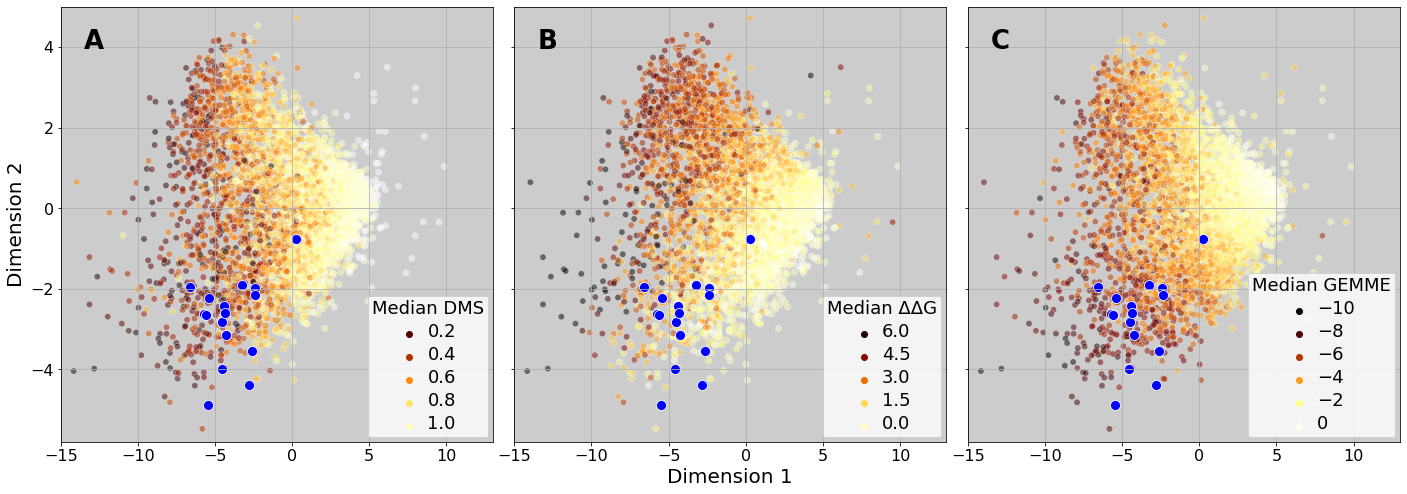

In [30]:
dms_mean_actsite = pd.merge(work_enzyme_data_mean[work_enzyme_data_mean['ddG'].notna()][['uniprot_id', 'u_pos']].drop_duplicates(), 
                       ACT_SITE, on=['uniprot_id', 'u_pos'], how='inner', validate='1:1')
dms_mean_actsite['dpos_id'] = dms_mean_actsite['uniprot_id'] + '_' + dms_mean_actsite['u_pos'].astype(int).astype(str)

vis_data = enzyme_mean_output.copy()
vis_data.index = vis_data.dpos_id
vis_data['-ddg_median'] = -vis_data['ddg_median']
hue_map = dict(zip(['ddg_median', 'gemme_median', 'score_median', 'hypho_score_med'],
                   ['Median ΔΔG', 'Median GEMME', 'Median DMS', '  Median DMS on\naliphatic variants']))
vis_data = vis_data.rename(columns=hue_map)

fig, axs = plt.subplots(1,3,figsize=(24,8), sharex=True, sharey=True)
axs = axs.reshape(-1)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.set_facecolor('w')
hue_target = dict(zip([0,1,2],['Median DMS', 'Median ΔΔG', 'Median GEMME']))
# To diminish the influence of extreme values on the color palette.
norms = dict(zip([0,1,2], [(0.0001, 0.98),(0.01, 0.99),(0.001, 1)])) 

for i in range(3):
    set_handle = True
    if i == 2:
        set_handle = False
    foo(axs[i], vis_data, 'PLSCanonical', hue_target[i], annot=dms_mean_actsite.query("is_reference==True")['dpos_id'], 
        hue_norm_quart=norms[i], set_handle=set_handle)
axs[0].set_ylabel('Dimension 2', fontsize=20)
axs[1].set_xlabel('Dimension 1', fontsize=20)
axs[0].set_xlim([-15, 13])
axs[0].set_ylim([-5.8, 5])
for i, char in enumerate('ABC'):
    axs[i].text(-13.5,3.95,char,fontsize=26, weight='bold',)
plt.show()